In [2]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 4.9 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unidecode

nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/rnn/all-data.csv',
                 encoding='ISO-8859-1',
                 names=['sentinment', 'content']
                 )
df.head(10)

,sentinment,content
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
5,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
6,positive,"For the last quarter of 2010 , Componenta 's n..."
7,positive,"In the third quarter of 2010 , net sales incre..."
8,positive,Operating profit rose to EUR 13.1 mn from EUR ...
9,positive,"Operating profit totalled EUR 21.1 mn , up fro..."


In [5]:
classes = {
    class_name: idx
    for idx, class_name in enumerate(df.sentinment.unique().tolist())
    }
classes

{'neutral': 0, 'negative': 1, 'positive': 2}

In [7]:
# Preprocessing data

english_stopwords = stopwords.words('english')
stemmer = PorterStemmer()

def text_normalize(text):
  # Lowercase the input
  text = text.lower()

  # The function takes as string object
  # possibly containing non-ASCII characters
  # and return a string that contain safely encoded to ASCII
  text = unidecode.unidecode(text)

  # Remove whitespace
  text = text.strip()

  # Remove non-word or number
  text = re.sub(r'[^\w\s]', '', text)

  # Remove puntual words
  text = ' '.join([word for word in text.split() if word not in english_stopwords])


  # Reducing words to their root or based form by chopping off prefix or suffix
  text = ' '.join([stemmer.stem(word) for word in text.split(' ')])

  return text


assert text_normalize('30 \U0001d5c4\U0001d5c6/\U0001d5c1 fished 1^') == '30 kmh fish 1'

In [11]:
# Build a vocabulary
vocab = []

for sentence in df.content.tolist():
  for word in text_normalize(sentence).split(' '):
    if word not in vocab:
      vocab.append(word)

# Add UNK for unknown word
vocab.append('UNK')

# Add PAD for empty string that added into to sastify the length
vocab.append('PAD')
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for idx, word in enumerate(vocab)}
vocab_size = len(vocab)
print(vocab_size)
print(vocab[:100])


8909
['accord', 'gran', 'compani', 'plan', 'move', 'product', 'russia', 'although', 'grow', 'technopoli', 'develop', 'stage', 'area', 'less', '100000', 'squar', 'meter', 'order', 'host', 'work', 'comput', 'technolog', 'telecommun', 'statement', 'said', 'intern', 'electron', 'industri', 'elcoteq', 'laid', 'ten', 'employe', 'tallinn', 'facil', 'contrari', 'earlier', 'layoff', 'contract', 'rank', 'offic', 'worker', 'daili', 'postime', 'report', 'new', 'plant', 'would', 'increas', 'capac', 'meet', 'expect', 'demand', 'improv', 'use', 'raw', 'materi', 'therefor', 'profit', 'updat', 'strategi', 'year', '20092012', 'baswar', 'target', 'longterm', 'net', 'sale', 'growth', 'rang', '20', '40', 'oper', 'margin', '10', 'financ', 'aspocomp', 'aggress', 'pursu', 'increasingli', 'focus', 'hdi', 'print', 'circuit', 'board', 'pcb', 'last', 'quarter', '2010', 'componenta', 'doubl', 'eur131m', 'eur76m', 'period', 'zero', 'pretax', 'loss', 'eur7m', 'third', '52', 'eur']


In [12]:
# Build a transfomation function that convert every word in a sentence to an array of tokens of index in our vocab
def transform(text: str, word_to_idx: dict, max_seq_len: int) -> list:
  tokens = []

  for word in text_normalize(text).split(' '):
    if word in word_to_idx.keys():
      tokens.append(word_to_idx[word])
    else:
      tokens.append(word_to_idx['UNK'])

  if len(tokens) < max_seq_len:
    tokens = tokens + [word_to_idx['PAD']] * (max_seq_len - len(tokens))
  else:
    tokens = tokens[:max_seq_len]

  return tokens

In [68]:
# Prepare data for train, val and test

val_size = 0.2
test_size = 0.1
is_shuffle = True

texts = df.content.tolist()
labels = df.sentinment.tolist()
max_seq_len = 32

X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=test_size, shuffle=is_shuffle)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, shuffle=is_shuffle)

In [69]:
class FinancialNewsDataset(Dataset):
  def __init__(self, texts: list, labels: list, word_to_idx: dict, max_seq_len: int, transform = None):
    self.texts = texts
    self.labels = labels
    self.word_to_idx = word_to_idx
    self.max_seq_len = max_seq_len
    self.transform = transform

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = self.texts[idx]
    labels = self.labels[idx]

    if self.transform:
      text = transform(text, self.word_to_idx, self.max_seq_len)

    return torch.tensor(text), torch.tensor(classes[labels])


max_seq_len = 100

# Instantiate the datasets
train_dataset = FinancialNewsDataset(X_train, y_train, word_to_idx, max_seq_len, transform)
val_dataset = FinancialNewsDataset(X_val, y_val, word_to_idx, max_seq_len, transform)
test_dataset = FinancialNewsDataset(X_test, y_test, word_to_idx, max_seq_len, transform)

# Wrap the datasets with DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [70]:
X_train[10:12]

['Initial estimated total value of the contract was 250 000 Euros , excluding VAT .',
 'Excluding non-recurring items , pre-tax profit surged 45 % to EUR80m .']

In [71]:
train_dataset[10]

(tensor([ 486,  274,  111,  140,   37, 1359,  779,  306, 5562, 3305, 8908, 8908,
         8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908,
         8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908,
         8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908,
         8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908,
         8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908,
         8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908,
         8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908, 8908,
         8908, 8908, 8908, 8908]),
 tensor(0))

In [72]:
class SentimentClassifier(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_size, n_layers, n_classes, dropout_prob, word_to_idx):

    super(SentimentClassifier, self).__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=word_to_idx['PAD'])
    self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
    self.nom = nn.LayerNorm(hidden_size)
    self.dropout = nn.Dropout(dropout_prob)
    self.fc1 = nn.Linear(hidden_size, 16)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(16, n_classes)

  def forward(self, x):
    x = self.embedding(x)
    x, _ = self.rnn(x)
    x = self.nom(x[:, -1, :])
    x = self.dropout(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x


In [73]:
n_classes = len(list(classes.keys()))
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SentimentClassifier(vocab_size, embedding_dim, hidden_size, n_layers, n_classes, dropout_prob, word_to_idx).to(device)

In [118]:
lr = 1e-4
epochs = 50

citerion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [119]:
def evaluate(model, val_loader, citerion):
  model.eval()
  correct = 0
  total = 0
  losses = []
  with torch.no_grad():
    for x, y in val_loader:
      x = x.to(device)
      y = y.to(device)

      y_pred = model(x)
      loss = citerion(y_pred, y)

      losses.append(loss.item())

      _, predicted = torch.max(y_pred.data, 1)
      total += y.size(0)
      correct += (predicted == y).sum().item()
    loss = np.mean(losses)
    acc = correct / total
    return loss, acc

def fit(model, train_loader, val_loader, citerion, optimizer, epochs):
  train_losses = []
  val_losses = []
  for epoch in range(epochs):
    batch_train_losses = []
    model.train()
    for x, y in train_loader:
      x = x.to(device)
      y = y.to(device)

      y_pred = model(x)
      loss = citerion(y_pred, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      batch_train_losses.append(loss.item())

    train_loss = np.mean(batch_train_losses)
    train_losses.append(train_loss)

    val_loss, val_acc = evaluate(model, val_loader, citerion)
    val_losses.append(val_loss)

    print(f'Epoch {epoch}: \t Train loss: {train_loss} \t Val loss: {val_loss} \t Val acc: {val_acc}')

  return train_losses, val_losses

train_losses, val_losses = fit(model, train_loader, val_loader, citerion, optimizer, epochs)

Epoch 0: 	 Train loss: 0.9307670387354764 	 Val loss: 0.9200591487543923 	 Val acc: 0.6162657502863689
Epoch 1: 	 Train loss: 0.9318896033547142 	 Val loss: 0.9186268193381173 	 Val acc: 0.6162657502863689
Epoch 2: 	 Train loss: 0.9281737782738425 	 Val loss: 0.9183365532330104 	 Val acc: 0.6162657502863689
Epoch 3: 	 Train loss: 0.9280092802914706 	 Val loss: 0.9184341090066093 	 Val acc: 0.6162657502863689
Epoch 4: 	 Train loss: 0.9303015459667553 	 Val loss: 0.917884111404419 	 Val acc: 0.6162657502863689
Epoch 5: 	 Train loss: 0.9307927575978365 	 Val loss: 0.9186138468129295 	 Val acc: 0.6162657502863689
Epoch 6: 	 Train loss: 0.9289773680947043 	 Val loss: 0.9168395229748317 	 Val acc: 0.6162657502863689
Epoch 7: 	 Train loss: 0.930230438709259 	 Val loss: 0.9175343811511993 	 Val acc: 0.6162657502863689
Epoch 8: 	 Train loss: 0.9272990031675858 	 Val loss: 0.918335850749697 	 Val acc: 0.6162657502863689
Epoch 9: 	 Train loss: 0.9294806046919389 	 Val loss: 0.9201062832559858 	 V

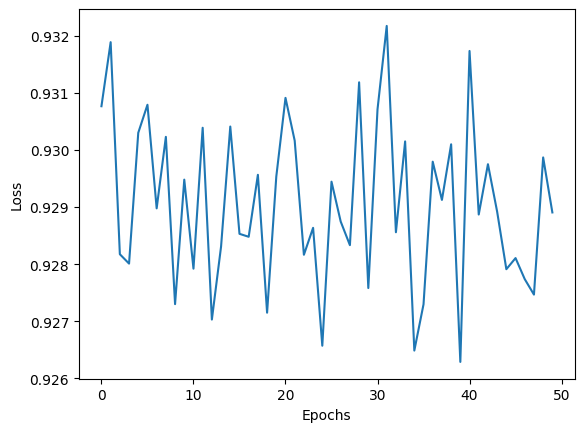

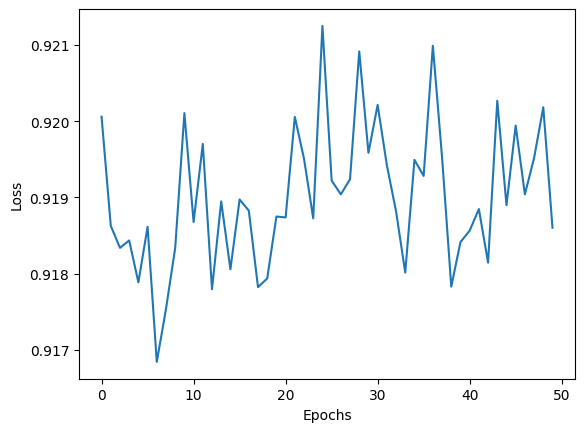

In [120]:
def draw_loss(losses):
  plt.plot(losses)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

draw_loss(train_losses)
draw_loss(val_losses)

In [121]:
test_loss, test_acc = evaluate(model, test_loader, citerion)
print(f'Test loss: {test_loss} \t Test acc: {test_acc}')

Test loss: 0.9317956939339638 	 Test acc: 0.6


In [ ]:
model.eval()

for indx in range(len(df)):
  text_input = df['content'][indx]

  indices = transform(text_input, word_to_idx, max_seq_len)
  indices = torch.tensor(indices).unsqueeze(0).to(device)

  output = model(indices)

  probabilities = torch.nn.functional.softmax(output, dim=1)
  predicted_class = torch.argmax(probabilities, dim=1).item()

  if predicted_class != 0:

    print(f'Prediction: {predicted_class}, grount-truth: {df['sentinment'][indx]}')
